# ML methods, week 12 demo

## Libraries and settings

In [6]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

### Target variable numerical (house price) or categorical (diabetes)

## Housing data

In [84]:
# Corrected Boston Housing data by Bivand, Nowosad and Lovelace
# https://jakubnowosad.com/spData/reference/boston.html
dfo = pd.read_csv("boston_corrected.tsv", sep='\t', skiprows=9)

In [85]:
dfo.head(2)

,OBS.,TOWN,TOWN#,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,...,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1,Nahant,0,2011,-70.955,42.2550,24.0,24.0,0.00632,18.0,...,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.9,4.98
1,2,Swampscott,1,2021,-70.950,42.2875,21.6,21.6,0.02731,0.0,...,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14


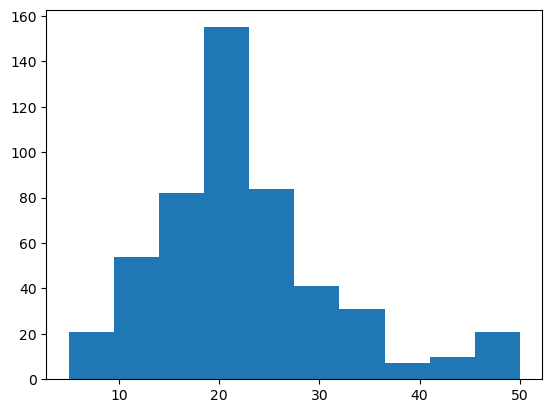

In [157]:
plt.hist(dfo.CMEDV)
plt.show()

In [158]:
from scipy.stats.mstats import normaltest
normaltest(dfo.CMEDV.values)
# is not a Normal distribution

NormaltestResult(statistic=91.57490454794716, pvalue=1.3024532297084256e-20)

In [86]:
dfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   OBS.     506 non-null    int64  
 1   TOWN     506 non-null    object 
 2   TOWN#    506 non-null    int64  
 3   TRACT    506 non-null    int64  
 4   LON      506 non-null    float64
 5   LAT      506 non-null    float64
 6   MEDV     506 non-null    float64
 7   CMEDV    506 non-null    float64
 8   CRIM     506 non-null    float64
 9   ZN       506 non-null    float64
 10  INDUS    506 non-null    float64
 11  CHAS     506 non-null    int64  
 12  NOX      506 non-null    float64
 13  RM       506 non-null    float64
 14  AGE      506 non-null    float64
 15  DIS      506 non-null    float64
 16  RAD      506 non-null    int64  
 17  TAX      506 non-null    int64  
 18  PTRATIO  506 non-null    float64
 19  B        506 non-null    float64
 20  LSTAT    506 non-null    float64
dtypes: float64(14), 

In [299]:
df = dfo.drop(['OBS.', 'LON', 'LAT', 'TRACT', 'TOWN', 'TOWN#', 'MEDV'], axis=1, inplace=False)

In [88]:
df.corr()

,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
CMEDV,1.000000,-0.389582,0.360386,-0.484754,0.175663,-0.429300,0.696304,-0.377999,0.249315,-0.384766,-0.471979,-0.505655,-0.740836
CRIM,-0.389582,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,0.455621
ZN,0.360386,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,-0.412995
INDUS,-0.484754,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,0.603800
CHAS,0.175663,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,-0.053929
NOX,-0.429300,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,0.590879
RM,0.696304,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,-0.613808
AGE,-0.377999,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,0.602339
DIS,0.249315,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,-0.496996
RAD,-0.384766,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,0.488676


<Axes: >

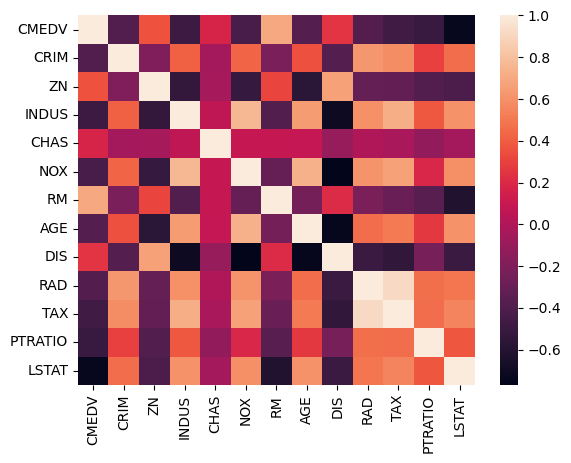

In [91]:
sns.heatmap(df.corr(), annot=False)

In [263]:
# CMEDV = corrected median house value
y = df.CMEDV
print(y.shape)
print(y[:3])

(506,)
0    24.0
1    21.6
2    34.7
Name: CMEDV, dtype: float64


In [ ]:
# refresh housing data
df = dfo.drop(['OBS.', 'LON', 'LAT', 'TRACT', 'TOWN', 'TOWN#', 'MEDV'], axis=1, inplace=False)
y = df.CMEDV
X = df.drop('CMEDV')

## Linear Regression

In [264]:
# one feature (avg number of rooms in a house)
X = np.array(df.RM).reshape(-1,1)
print(X.shape)
print(X[:3])

(506, 1)
[[6.5750]
 [6.4210]
 [7.1850]]


In [265]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape: {}, X_test shape: {}, y_train shape: {}, y_test shape {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train shape: (404, 1), X_test shape: (102, 1), y_train shape: (404,), y_test shape (102,)


In [266]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [268]:
print(model.coef_)
print(model.intercept_)

[9.3449]
-36.21968671198455


In [267]:
y_pred = model.predict(X_test).reshape(-1,1)
print(y_pred.shape)
y_pred[:3]

(102, 1)


array([[23.7372],
       [26.9332],
       [19.6909]])

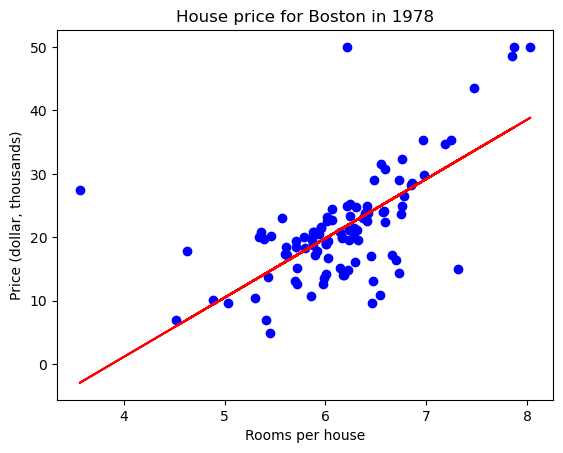

In [98]:
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red')
plt.title("House price for Boston in 1978")
plt.xlabel("Rooms per house")
plt.ylabel("Price (dollar, thousands)")
plt.show()

In [269]:
# accuracy?
model.score(X, y) 

0.48448244178977584

In [ ]:
# R-squared
r2_score(y_test, model.predict(X_test))

## Multiple variables for Linear Regression

In [276]:
# CRIM = crime rate; LSTAT = working class; NOX = air quality; PTRATIO = pupil:teacher ratio; DIS = distance to employment centres; RAD = radial road proximity; RM = rooms
X = df[['ZN', 'TAX', 'CRIM', 'DIS', 'LSTAT', 'NOX', 'PTRATIO', 'RAD', 'RM']]
print(X.shape)
print(X[:3])

(506, 9)
     ZN  TAX     CRIM     DIS  LSTAT    NOX  PTRATIO  RAD     RM
0  18.0  296  0.00632  4.0900   4.98  0.538     15.3    1  6.575
1   0.0  242  0.02731  4.9671   9.14  0.469     17.8    2  6.421
2   0.0  242  0.02729  4.9671   4.03  0.469     17.8    2  7.185


In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape: {}, X_test shape: {}, y_train shape: {}, y_test shape {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train shape: (404, 9), X_test shape: (102, 9), y_train shape: (404,), y_test shape (102,)


In [278]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [279]:
y_pred = model.predict(X_test).reshape(-1,1)
y_pred.shape

(102, 1)

In [280]:
print(model.coef_)
print(model.intercept_)

[0.0474 -0.0136 -0.1264 -1.5799 -0.5593 -17.2764 -0.9347 0.2971 3.6905]
41.85951887619595


In [285]:
# R squared
r2 = r2_score(y_test, model.predict(X_test))
print(r2)

0.710787123424206


In [290]:
# adjust R-squared
print(f"{X.shape[1]} features")
1 - (1-r2) * (len(y)-1) / (len(y)-X.shape[1] -1)

9 features


0.7055393091315001

In [286]:
# Accuracy?
print(model.score(X, y))

0.732129058069559


# Diabetes PIMA data

In [21]:
dfo = pd.read_csv("diabetes.csv")
dfo.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1


In [28]:
dfo.isnull().values.any()

False

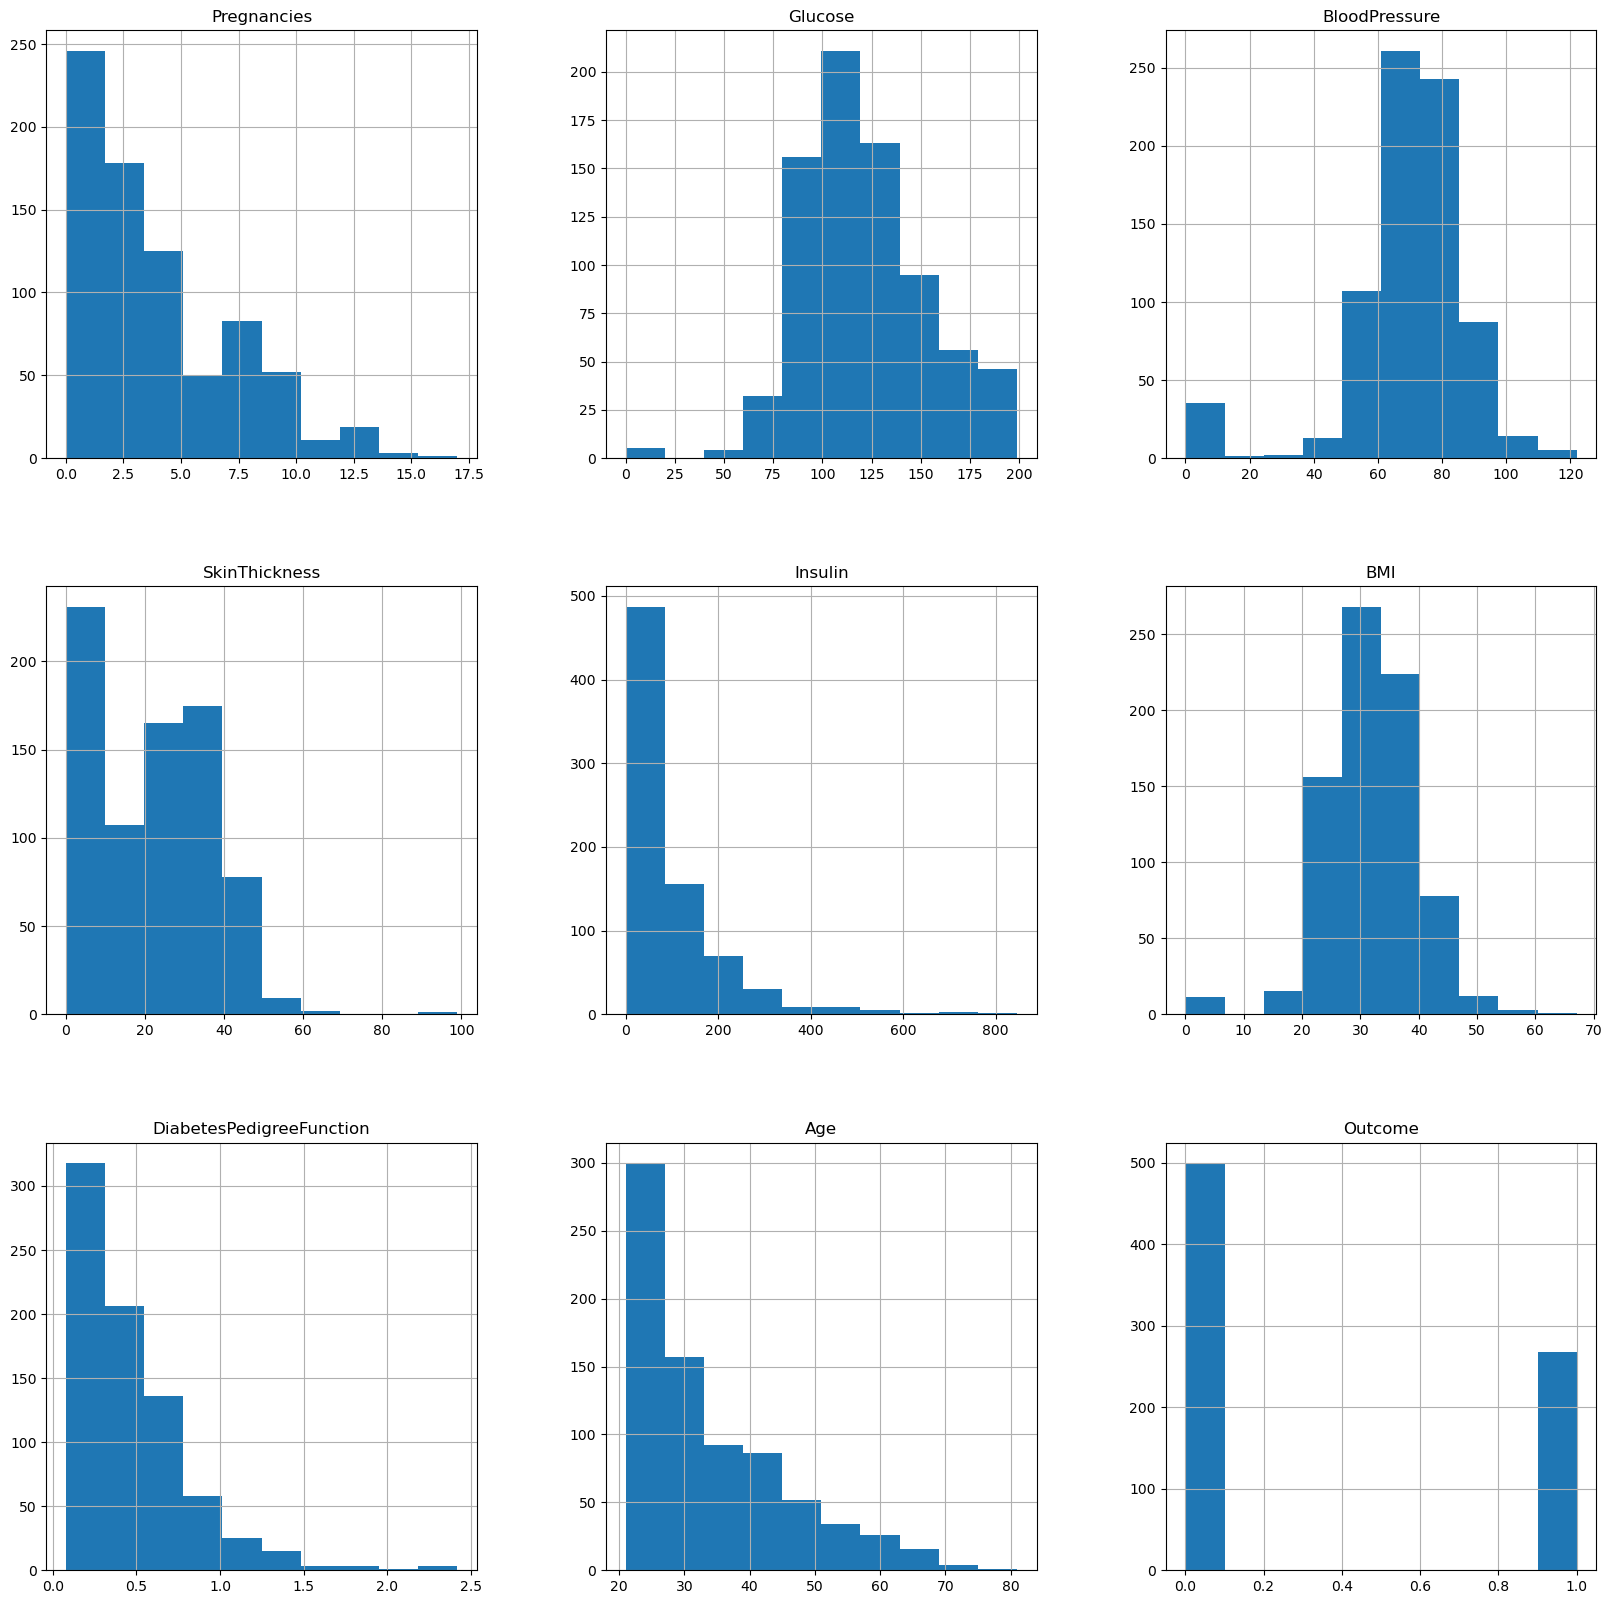

In [22]:
p = dfo.hist(figsize = (20,20))

In [23]:
(dfo == 0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [24]:
df = dfo.copy(deep=True)
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = dfo[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

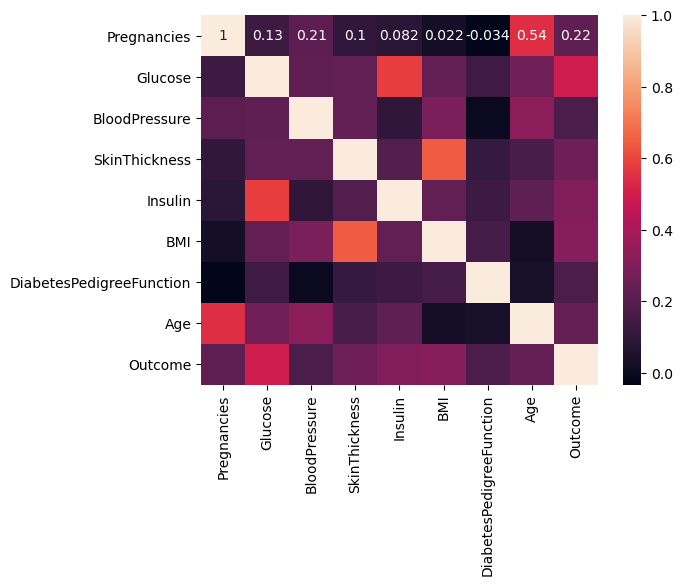

In [27]:
sns.heatmap(df.corr(), annot = True)
plt.show()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


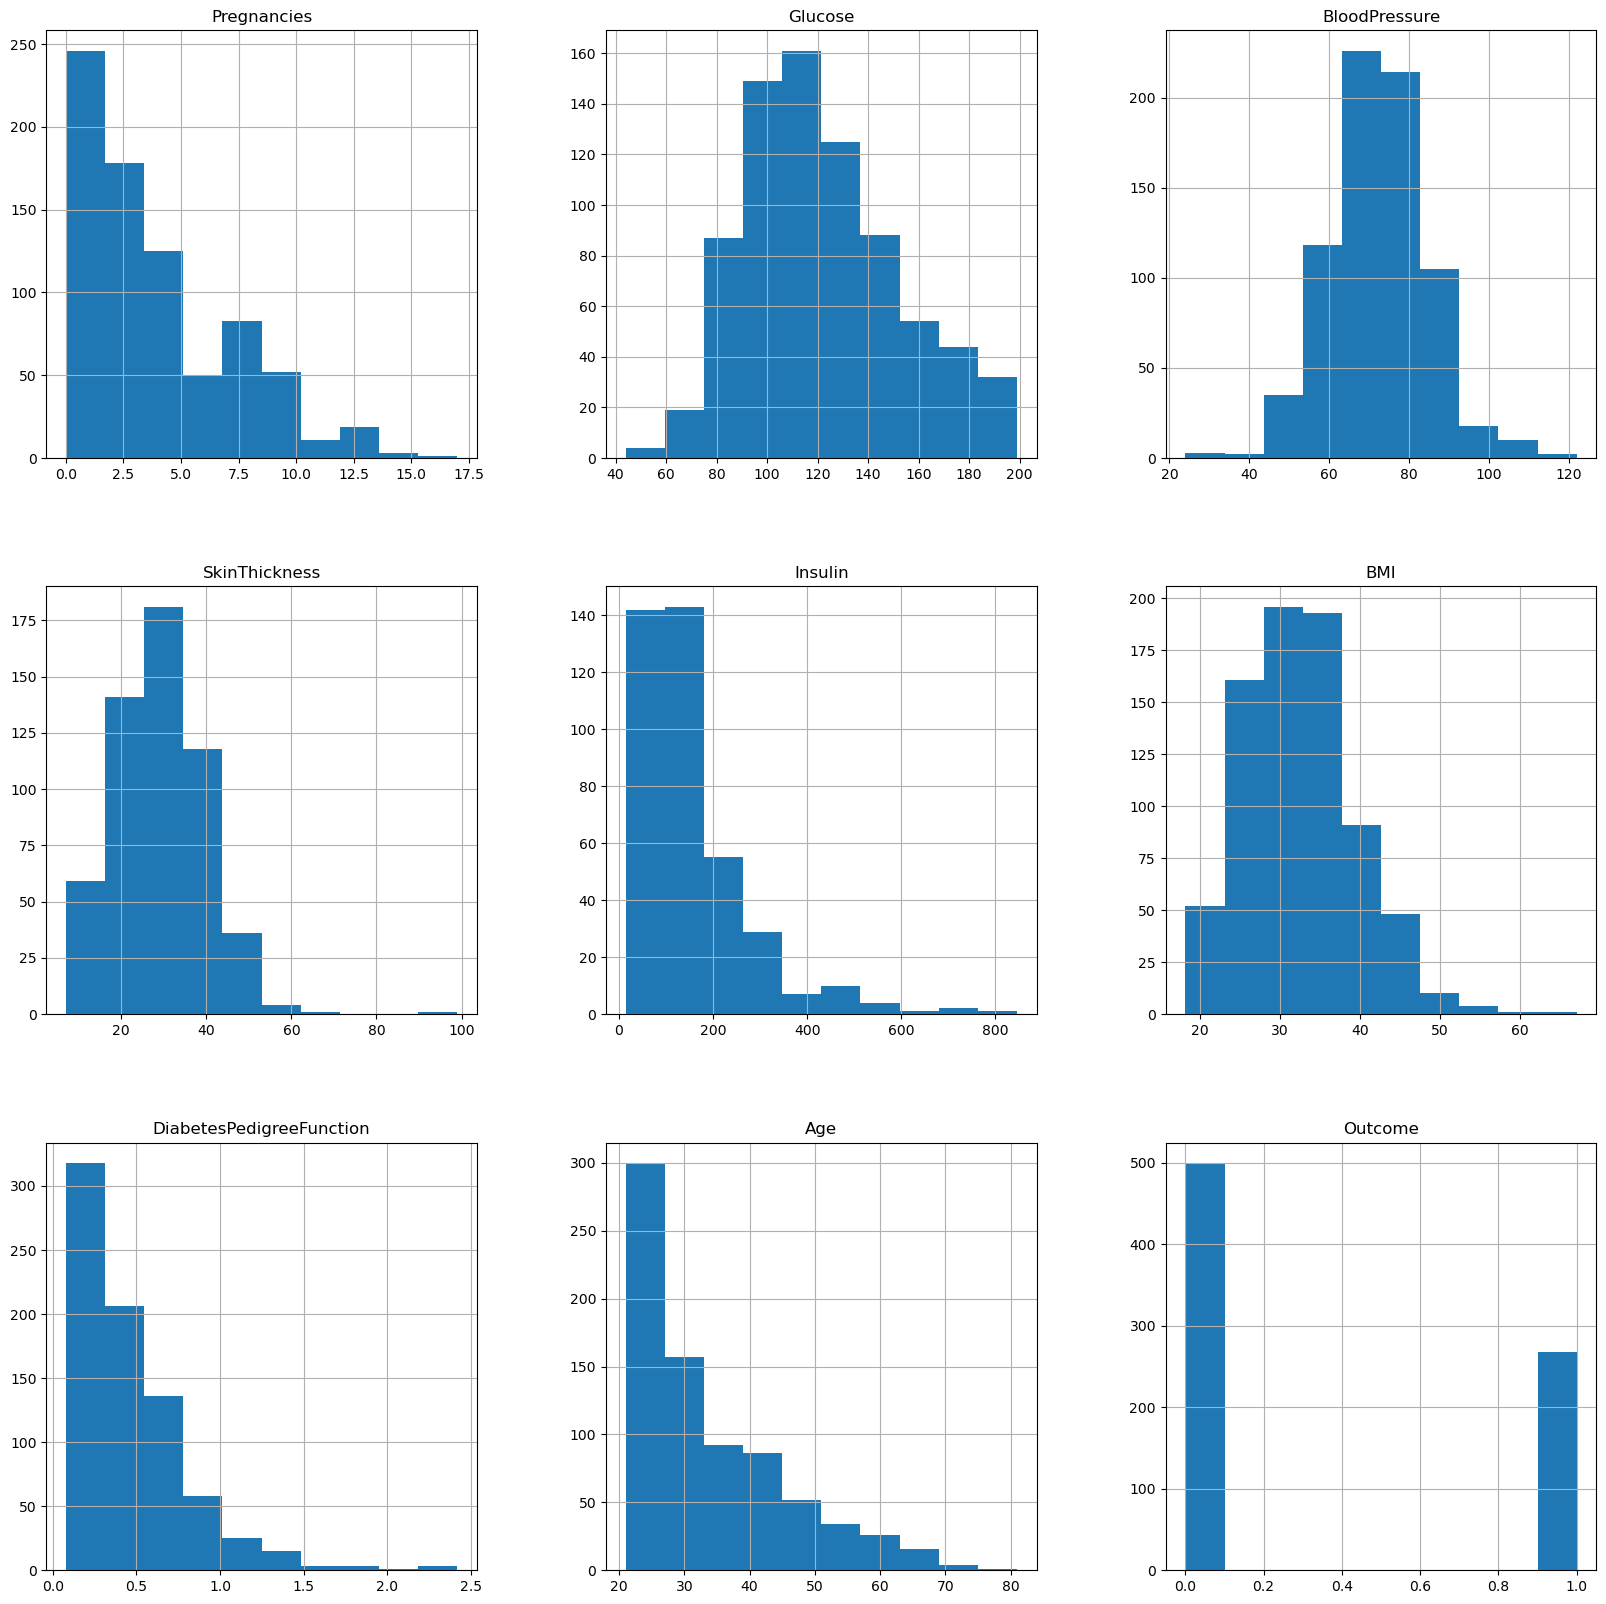

In [31]:
df.hist(figsize = (20,20))
plt.show()

Outcome
0    500
1    268
Name: count, dtype: int64


<Axes: xlabel='Outcome'>

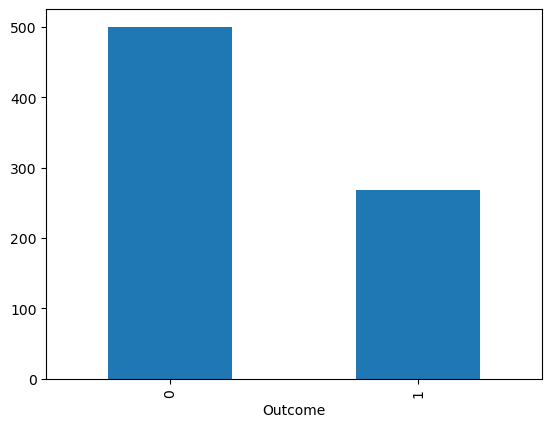

In [42]:
print(df.Outcome.value_counts())
df.Outcome.value_counts().plot(kind="bar")

In [49]:
df['Glucose'].fillna(df['Glucose'].mean(), inplace = True)
df['BloodPressure'].fillna(df['BloodPressure'].mean(), inplace = True)
df['SkinThickness'].fillna(df['SkinThickness'].mean(), inplace = True)
df['Insulin'].fillna(df['Insulin'].mean(), inplace = True)
df['BMI'].fillna(df['BMI'].mean(), inplace = True)

In [50]:
X = df.drop('Outcome', axis=1)
y = np.array(df.Outcome)
y = df.Outcome
print(type(X))
print(X.shape)
print(type(y))
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
(768, 8)
<class 'pandas.core.series.Series'>
(768,)


In [55]:
df_diabetes_zeros_to_mean = df.copy(deep=True)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(type(X_train))
print(X_train.shape)

<class 'pandas.core.frame.DataFrame'>
(614, 8)


In [52]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
print(type(X_train_scaled))
print(X_train_scaled[0])

<class 'numpy.ndarray'>
[-0.5264 -1.2583 0.0132 0.0473 0.0074 0.0150 -0.4907 -1.0359]


In [53]:
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled[0])

[0.6819 -0.7928 -1.1783 0.5049 0.4038 0.2376 -0.1164 0.8781]


In [54]:
print(type(y_train))
print(y_train[:5])

<class 'pandas.core.series.Series'>
60     0
618    1
346    0
294    0
231    1
Name: Outcome, dtype: int64


## Logistic Regression

In [312]:
# data refresh data, split, scale (if required)
df = pd.read_csv("diabetes.csv")
X = df.drop('Outcome', axis=1).to_numpy()
y = df.Outcome.to_numpy() #.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [243]:
model = LogisticRegression(C=0.01, max_iter=200)
model.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=200)

In [244]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [245]:
log_loss(y_test, y_pred)

9.596037590609113

In [246]:
confusion_matrix(y_test, y_pred)

array([[78, 21],
       [20, 35]])

In [247]:
print("%.4f" % accuracy_score(y_train, model.predict(X_train)))
print("%.4f" % accuracy_score(y_test, model.predict(X_test)))

0.7704
0.7338


In [248]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79        99
           1       0.62      0.64      0.63        55

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154



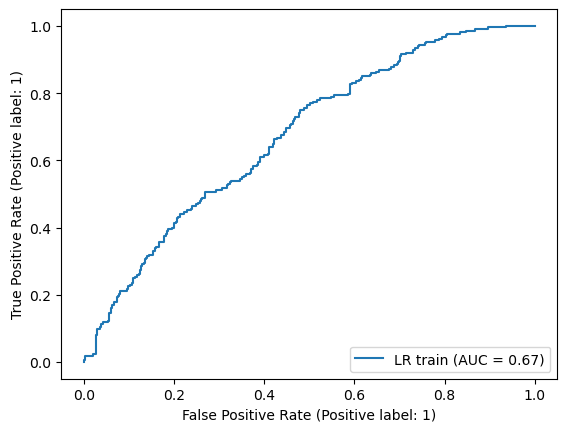

In [221]:
RocCurveDisplay.from_predictions(y_train, model.predict_proba(X_train_scaled)[:,1], name="LR train")  
plt.show()  

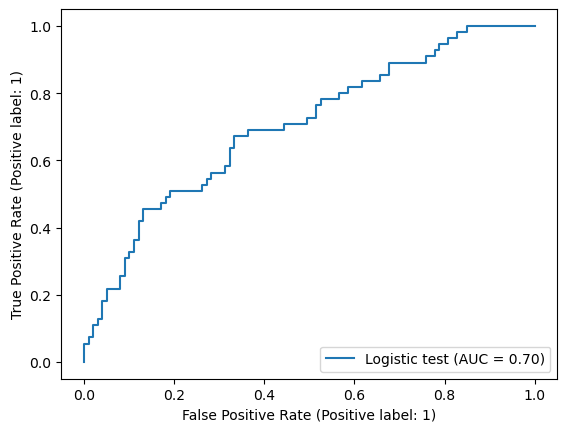

In [222]:
RocCurveDisplay.from_predictions(y_test, model.predict_proba(X_test_scaled)[:,1], name="Logistic test")  
plt.show()  

### Model 2 - L1, Saga, C=0.1 

In [236]:
model2 = LogisticRegression(C=0.1, penalty="l1", solver="saga", max_iter=2000)
model2.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=2000, penalty='l1', solver='saga')

In [237]:
y_pred = model2.predict(X_test)

In [238]:
log_loss(y_test, y_pred)

9.59603759060911

In [239]:
confusion_matrix(y_test, y_pred)

array([[91,  8],
       [33, 22]])

In [240]:
print("%.4f" % accuracy_score(y_train, model2.predict(X_train)))
print("%.4f" % accuracy_score(y_test, model2.predict(X_test)))

0.6710
0.7338


In [241]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.92      0.82        99
           1       0.73      0.40      0.52        55

    accuracy                           0.73       154
   macro avg       0.73      0.66      0.67       154
weighted avg       0.73      0.73      0.71       154



In [ ]:
# practice saving a model
from joblib inport dump, load
dump(model2, "logistic_model_2.joblib")

## k Nearest Neighbours

In [ ]:
# model is computed when predicting
# follows example at realpython.com/knn-python

In [348]:
abalone = pd.read_csv("../demo/abalone.csv")
abalone.head(2)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7


In [349]:
df = abalone.drop("Sex", axis=1)
df.shape

(4177, 8)

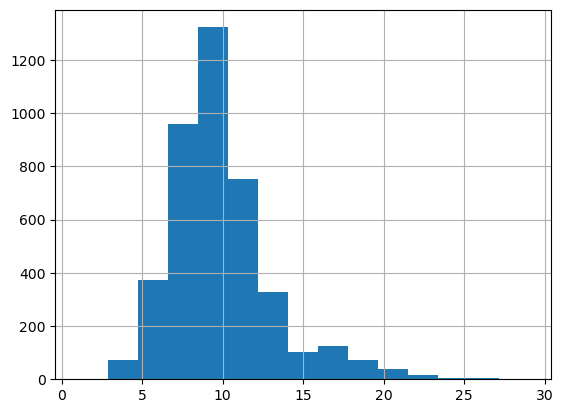

In [350]:
df["Rings"].hist(bins=15)
plt.show()

In [351]:
corr_matrix = df.corr()
corr_matrix["Rings"]

Length            0.556720
Diameter          0.574660
Height            0.557467
Whole weight      0.540390
Shucked weight    0.420884
Viscera weight    0.503819
Shell weight      0.627574
Rings             1.000000
Name: Rings, dtype: float64

In [353]:
X = df.drop("Rings", axis=1)
X = X.values # convert dataframe to np.array
X.shape

(4177, 7)

In [355]:
y = df.Rings
y = y.values

In [357]:
new_data_point = np.array([0.5, 0.4, 0.15, 1, 0.4, 0.2, 0.3])
distances = np.linalg.norm(X - new_data_point, axis=1)
print(distances.shape)
print(distances)

(4177,)
[0.5528 0.9002 0.3714 ... 0.2704 0.2295 1.1561]


In [359]:
k = 3
nearest_neighbour_ids =  distances.argsort()[:k]
nearest_neighbour_ids

array([  82,  723, 2978])

In [360]:
nn_rings = y[nearest_neighbour_ids]
nn_rings

array([16, 15,  8])

In [361]:
y_pred = nn_rings.mean()
y_pred

13.0

In [362]:
# redo using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [367]:
from sklearn.neighbors import KNeighborsRegressor
from math import sqrt
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [372]:
train_predicts = model.predict(X_train)
mse = mean_squared_error(y_train, train_predicts)
rmse = sqrt(mse)
print(np.format_float_positional(rmse, precision=4)) # error in years

1.6643


In [371]:
test_predicts = model.predict(X_test)
mse = mean_squared_error(y_test, test_predicts)
rmse = sqrt(mse)
#print("%.4f {rmse} years".)
print(np.format_float_positional(rmse, precision=4))


2.4072


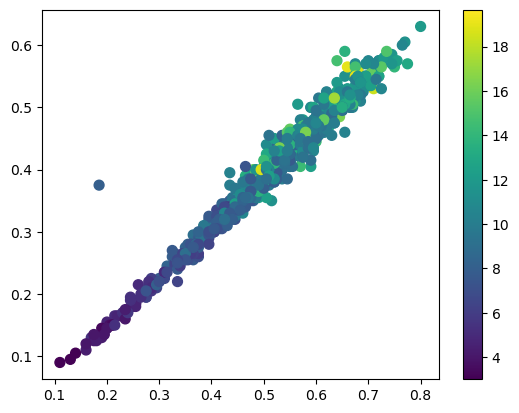

In [376]:
f, ax = plt.subplots()
points = ax.scatter(X_test[:,0], X_test[:,1], c=test_predicts, s=50)
f.colorbar(points)
plt.show()

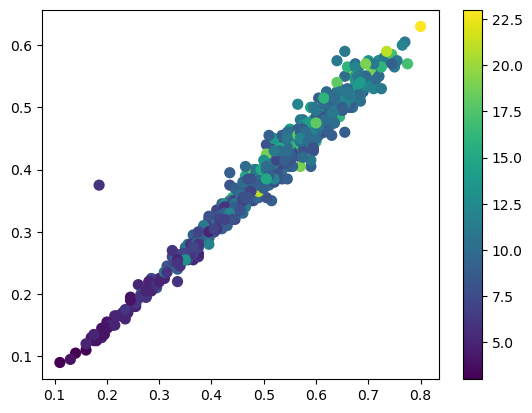

In [377]:
f, ax = plt.subplots()
points = ax.scatter(X_test[:,0], X_test[:,1], c=y_test, s=50)
f.colorbar(points)
plt.show()

In [378]:
from sklearn.model_selection import GridSearchCV
params = {"n_neighbors": range(1,50)}
gs_model = GridSearchCV(KNeighborsRegressor(), params)
gs_model.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50)})

In [379]:
gs_model.best_params_

{'n_neighbors': 22}

In [381]:
model = KNeighborsRegressor(n_neighbors=22)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=22)

In [383]:
train_predicts = model.predict(X_train)
mse = mean_squared_error(y_train, train_predicts)
print(sqrt(mse))
# less overfitting than k=3 - rmse higher for Training...

2.039052561655222


In [382]:
test_predicts = model.predict(X_test)
mse = mean_squared_error(y_test, test_predicts)
print(sqrt(mse))
# while on Testing, slightly better error at 2.2 years rather than 2.4

2.2090296228724826


In [385]:
parameters = {
    "n_neighbors": range(1, 40),
    "weights": ["uniform", "distance"]
}
gs_model = GridSearchCV(KNeighborsRegressor(), parameters)
gs_model.fit(X_train, y_train)
gs_model.best_params_

{'n_neighbors': 22, 'weights': 'distance'}

In [386]:
test_predicts = gs_model.predict(X_test)
mse = mean_squared_error(y_test, test_predicts)
print(sqrt(mse))
# a tiny improvement from RMSE 2.209 to 2.204

2.204098931339065


In [391]:
bagged_knn = KNeighborsRegressor(n_neighbors=22, weights="distance")
from sklearn.ensemble import BaggingRegressor
bag_model = BaggingRegressor(bagged_knn, n_estimators=100)
bag_model.fit(X_train, y_train)
test_preds_grid = bag_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds_grid)
print(sqrt(mse))
# tiny improvement and only on third run of ensemble bagging

2.202584667047977


## Decision Tree Regressor

In [455]:
# refresh housing data
df = dfo.drop(['OBS.', 'LON', 'LAT', 'TRACT', 'TOWN', 'TOWN#', 'MEDV'], axis=1, inplace=False)
y = df.CMEDV
X = df.drop('CMEDV', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [465]:
model = DecisionTreeRegressor(random_state=42)

In [466]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred[:7]

array([25.0000, 27.9000, 19.5000, 18.9000, 18.3000, 18.5000, 16.6000])

In [468]:
X.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [467]:
mean_squared_error(y_test, y_pred)

11.34127450980392

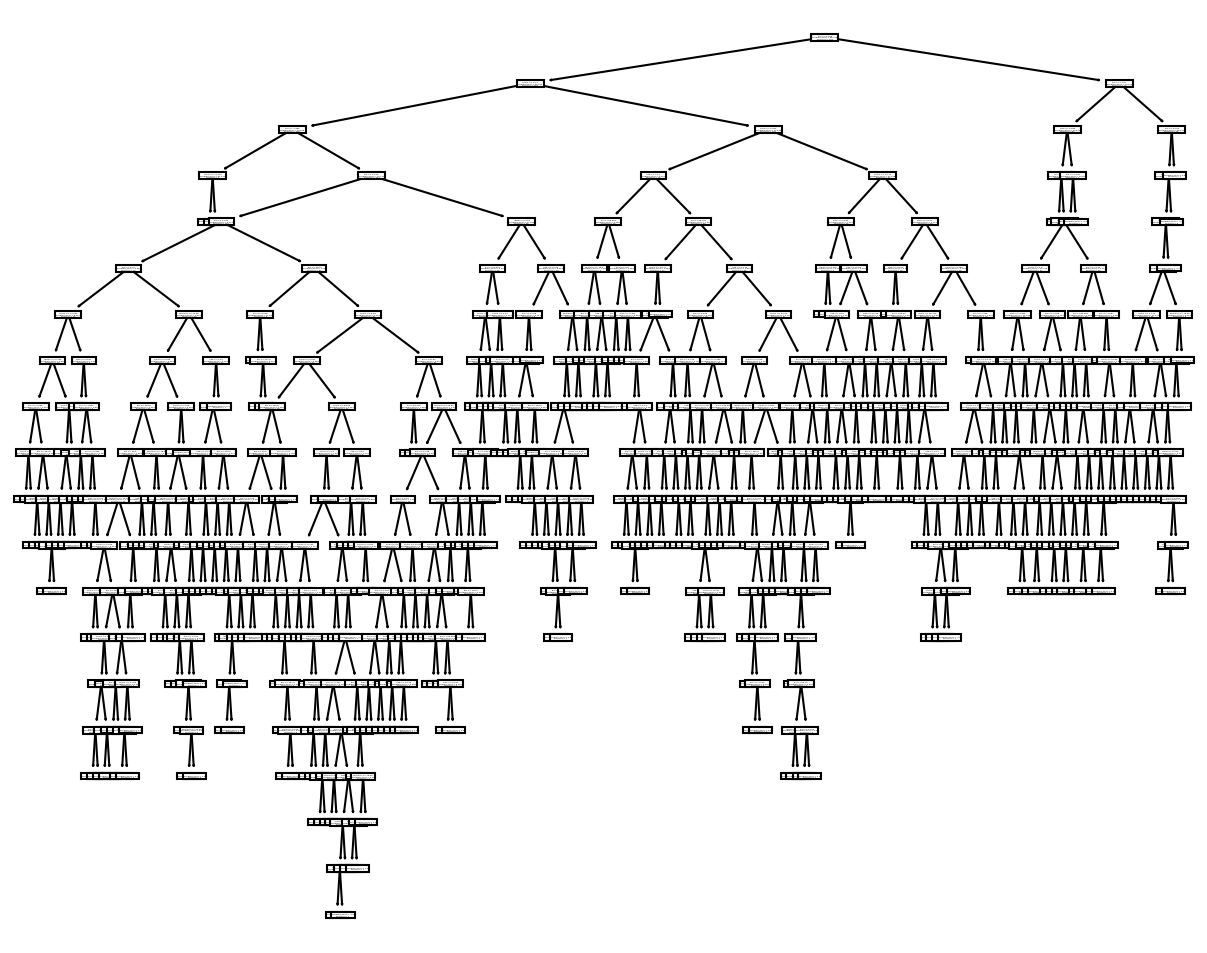

In [470]:
from sklearn import tree
plt.figure(figsize=(10,8), dpi=150)
tree.plot_tree(model)

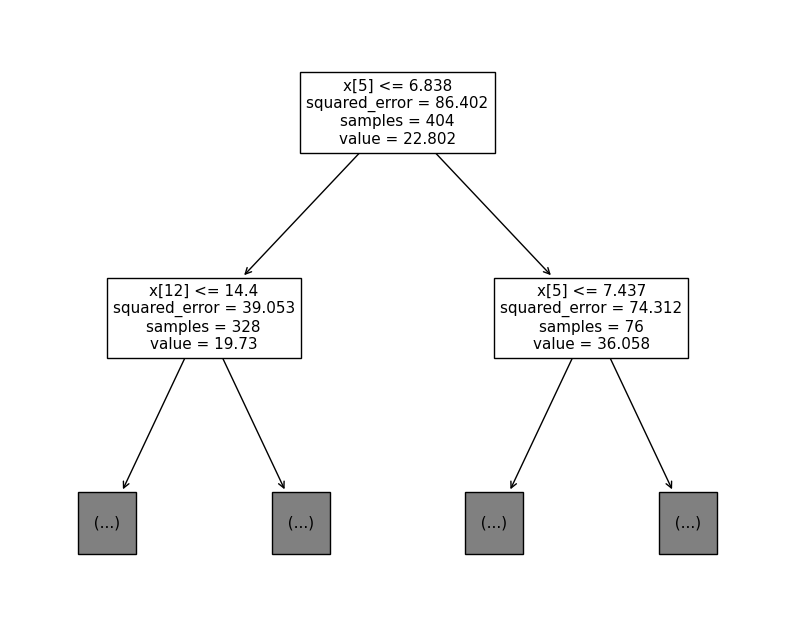

In [474]:
plt.figure(figsize=(10,8))
tree.plot_tree(model, max_depth=1)
plt.show()

In [461]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, max_depth=2, random_state=42)

In [462]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=200, random_state=42)

In [463]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

21.759466947932705

In [464]:
print(model.feature_names_in_)
model.feature_importances_
# RM and LSTAT are most important

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


array([0.0026, 0.0004, 0.0000, 0.0000, 0.0019, 0.5987, 0.0023, 0.0013,
       0.0000, 0.0000, 0.0000, 0.0000, 0.3927])

## Decision Tree Classifier

In [ ]:
# scaling not needed for decision tree

In [405]:
# data refresh (df as feature names are needded)
df = pd.read_csv("diabetes.csv")
X = df.drop('Outcome', axis=1)
y = df.Outcome
# X = df.drop('Outcome', axis=1).to_numpy()
# y = df.Outcome.to_numpy() #.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [422]:
y_test.value_counts()
# nearly twice as many 0 as 1 (diabetes outcome)

Outcome
0    99
1    55
Name: count, dtype: int64

In [406]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [434]:
y_prob_train = model.predict_proba(X_train)[:, 1]
print(np.unique(y_prob_train, return_counts=True))
roc_auc_train = roc_auc_score(y_train, y_prob_train)
print(roc_auc_train)

(array([0.0000, 1.0000]), array([401, 213]))
1.0


In [436]:
y_prob = model.predict_proba(X_test)[:, 1]
print(np.unique(y_prob, return_counts=True))
roc_auc = roc_auc_score(y_test, y_prob)
print("%.4f" % roc_auc)
# Training model was over-fitted, test AUROC is much lower

(array([0.0000, 1.0000]), array([92, 62]))
0.7525


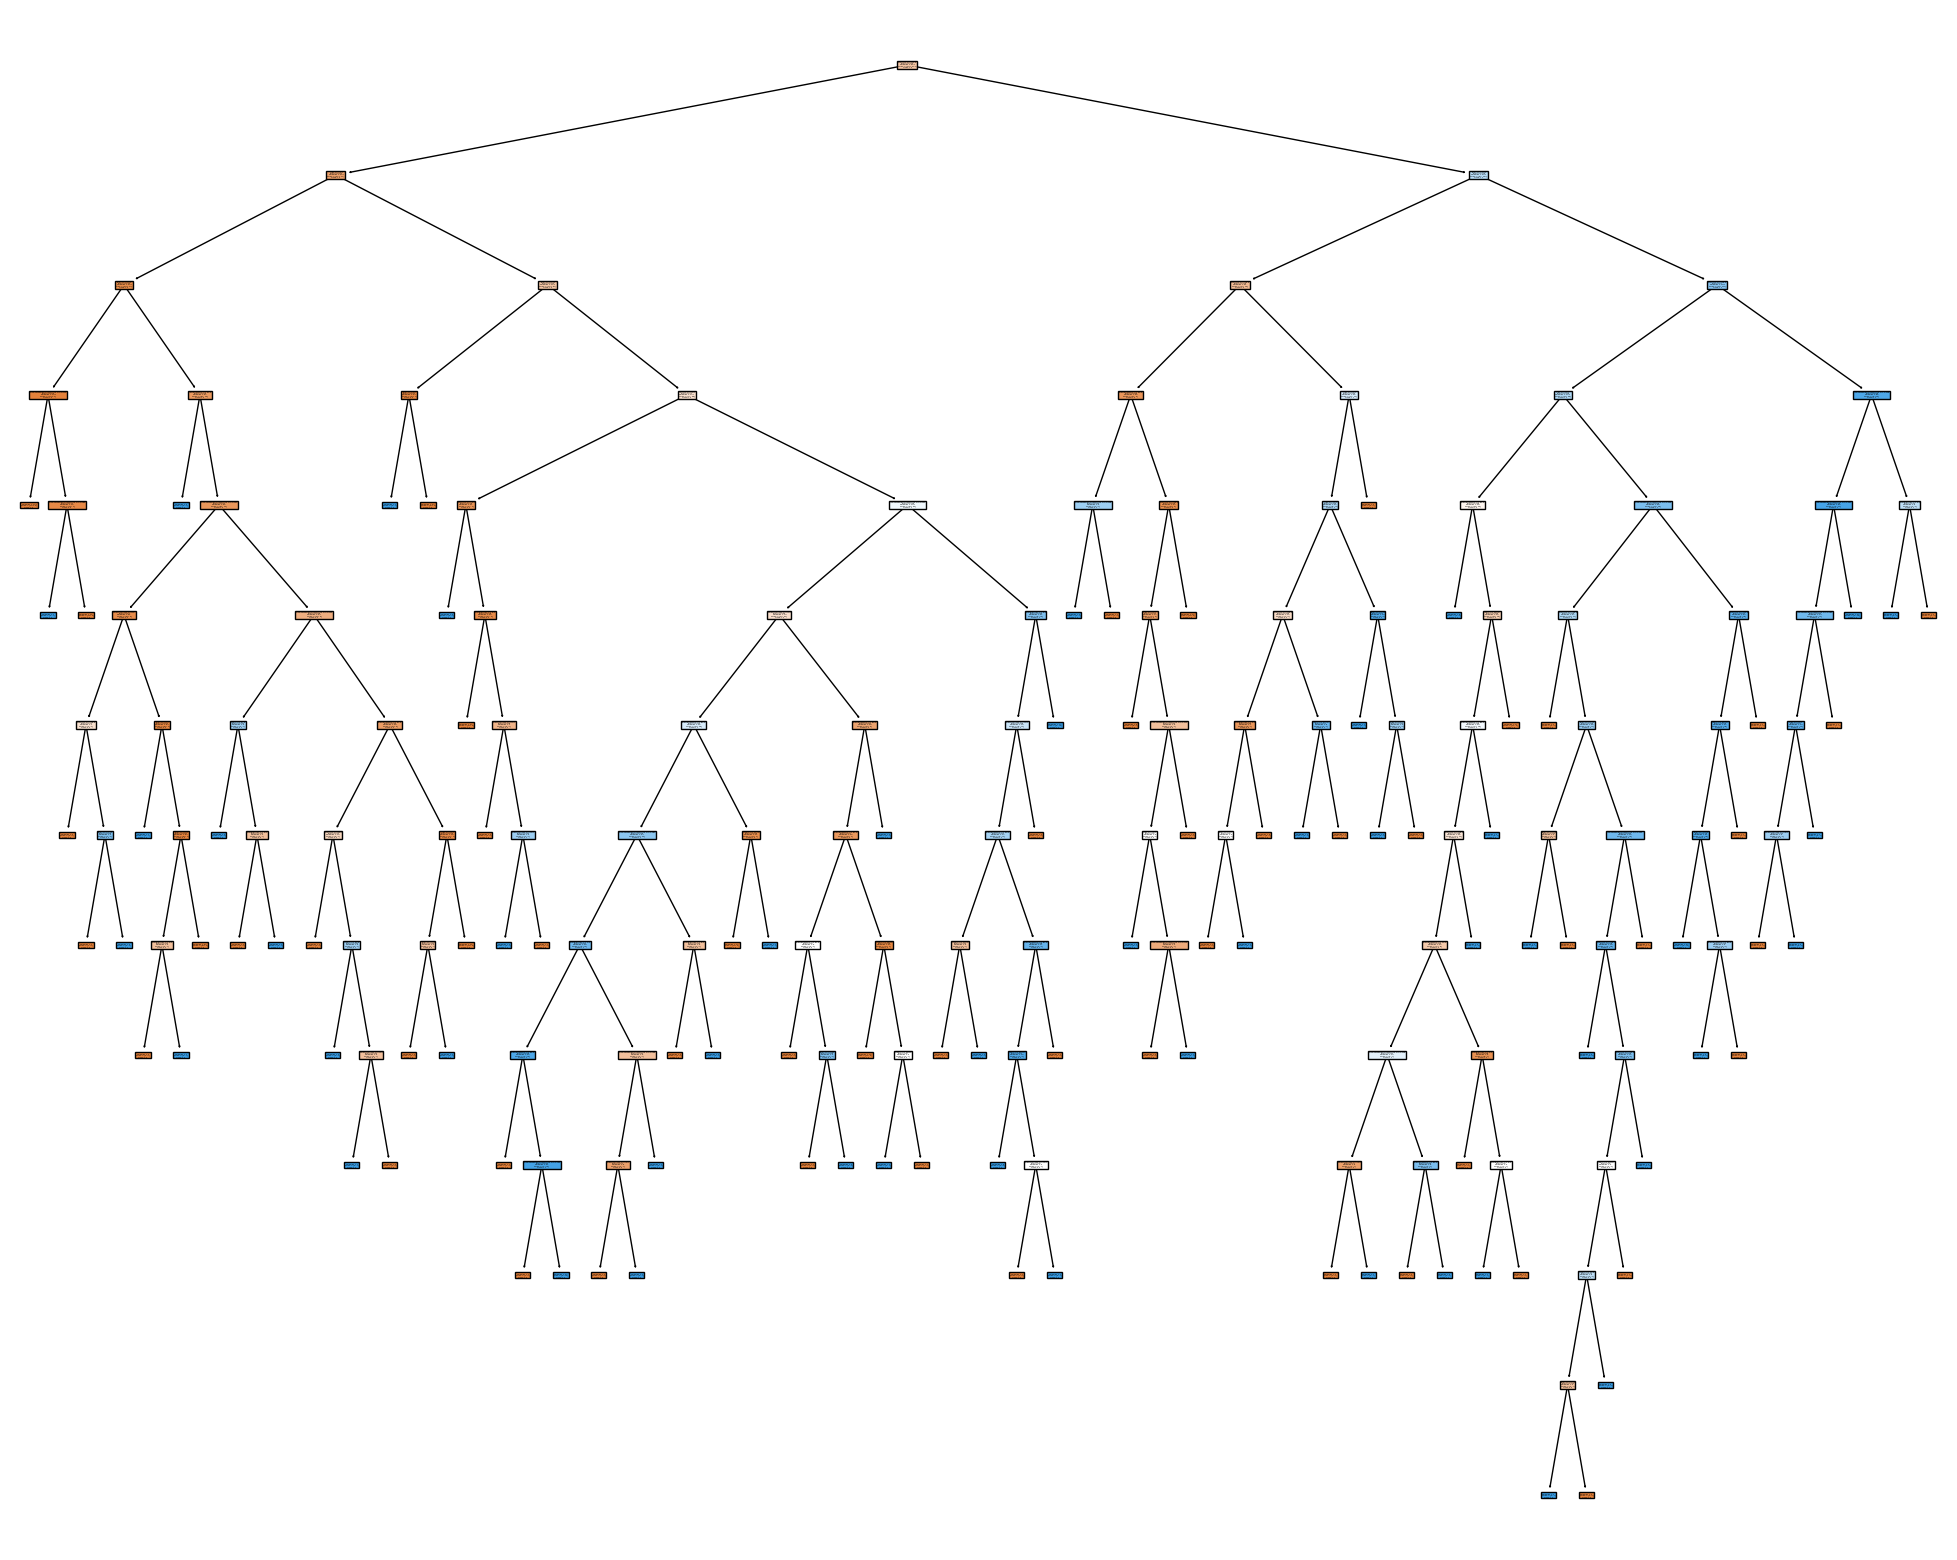

In [409]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(model, 
                   feature_names=df.columns,  
                   class_names=['0','1'],
                   filled=True)

In [410]:
model.feature_names_in_

array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype=object)

In [411]:
model.feature_importances_

array([0.0605, 0.3066, 0.1433, 0.0664, 0.0682, 0.1584, 0.0967, 0.1001])

<Axes: >

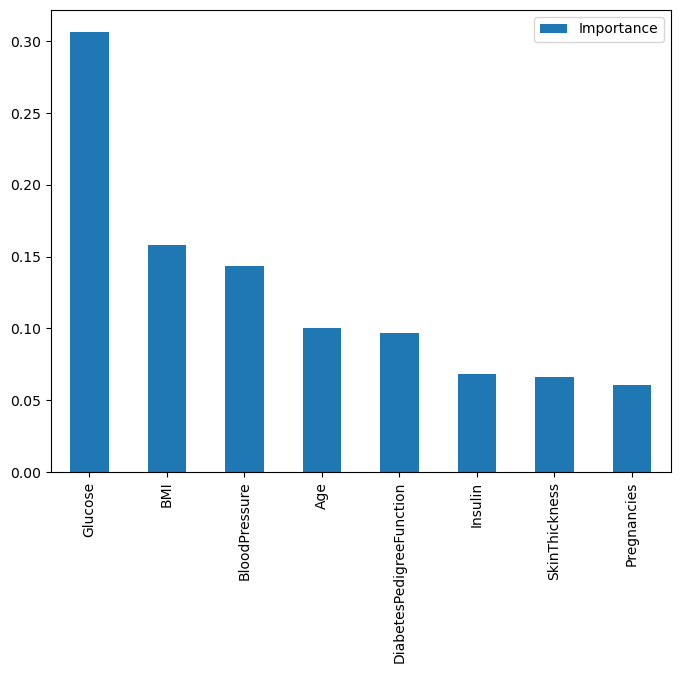

In [412]:
importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["Importance"])
importances.sort_values(by='Importance', ascending=False, inplace=True)
importances.plot(kind='bar', figsize=(8,6))

In [431]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[77 22]
 [15 40]]


### Tree-branching constrain to 2 levels 

In [423]:
model2 = DecisionTreeClassifier(max_depth=2, min_samples_leaf=2)
model2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=2)

In [426]:
y_prob = model2.predict_proba(X_test)[:, 1]
print(np.unique(y_prob, return_counts=True))

(array([0.0769, 0.3115, 0.3491, 0.7239]), array([50, 15, 45, 44]))


In [427]:
roc_auc = roc_auc_score(y_test, y_prob)
print(roc_auc)

0.7711662075298439


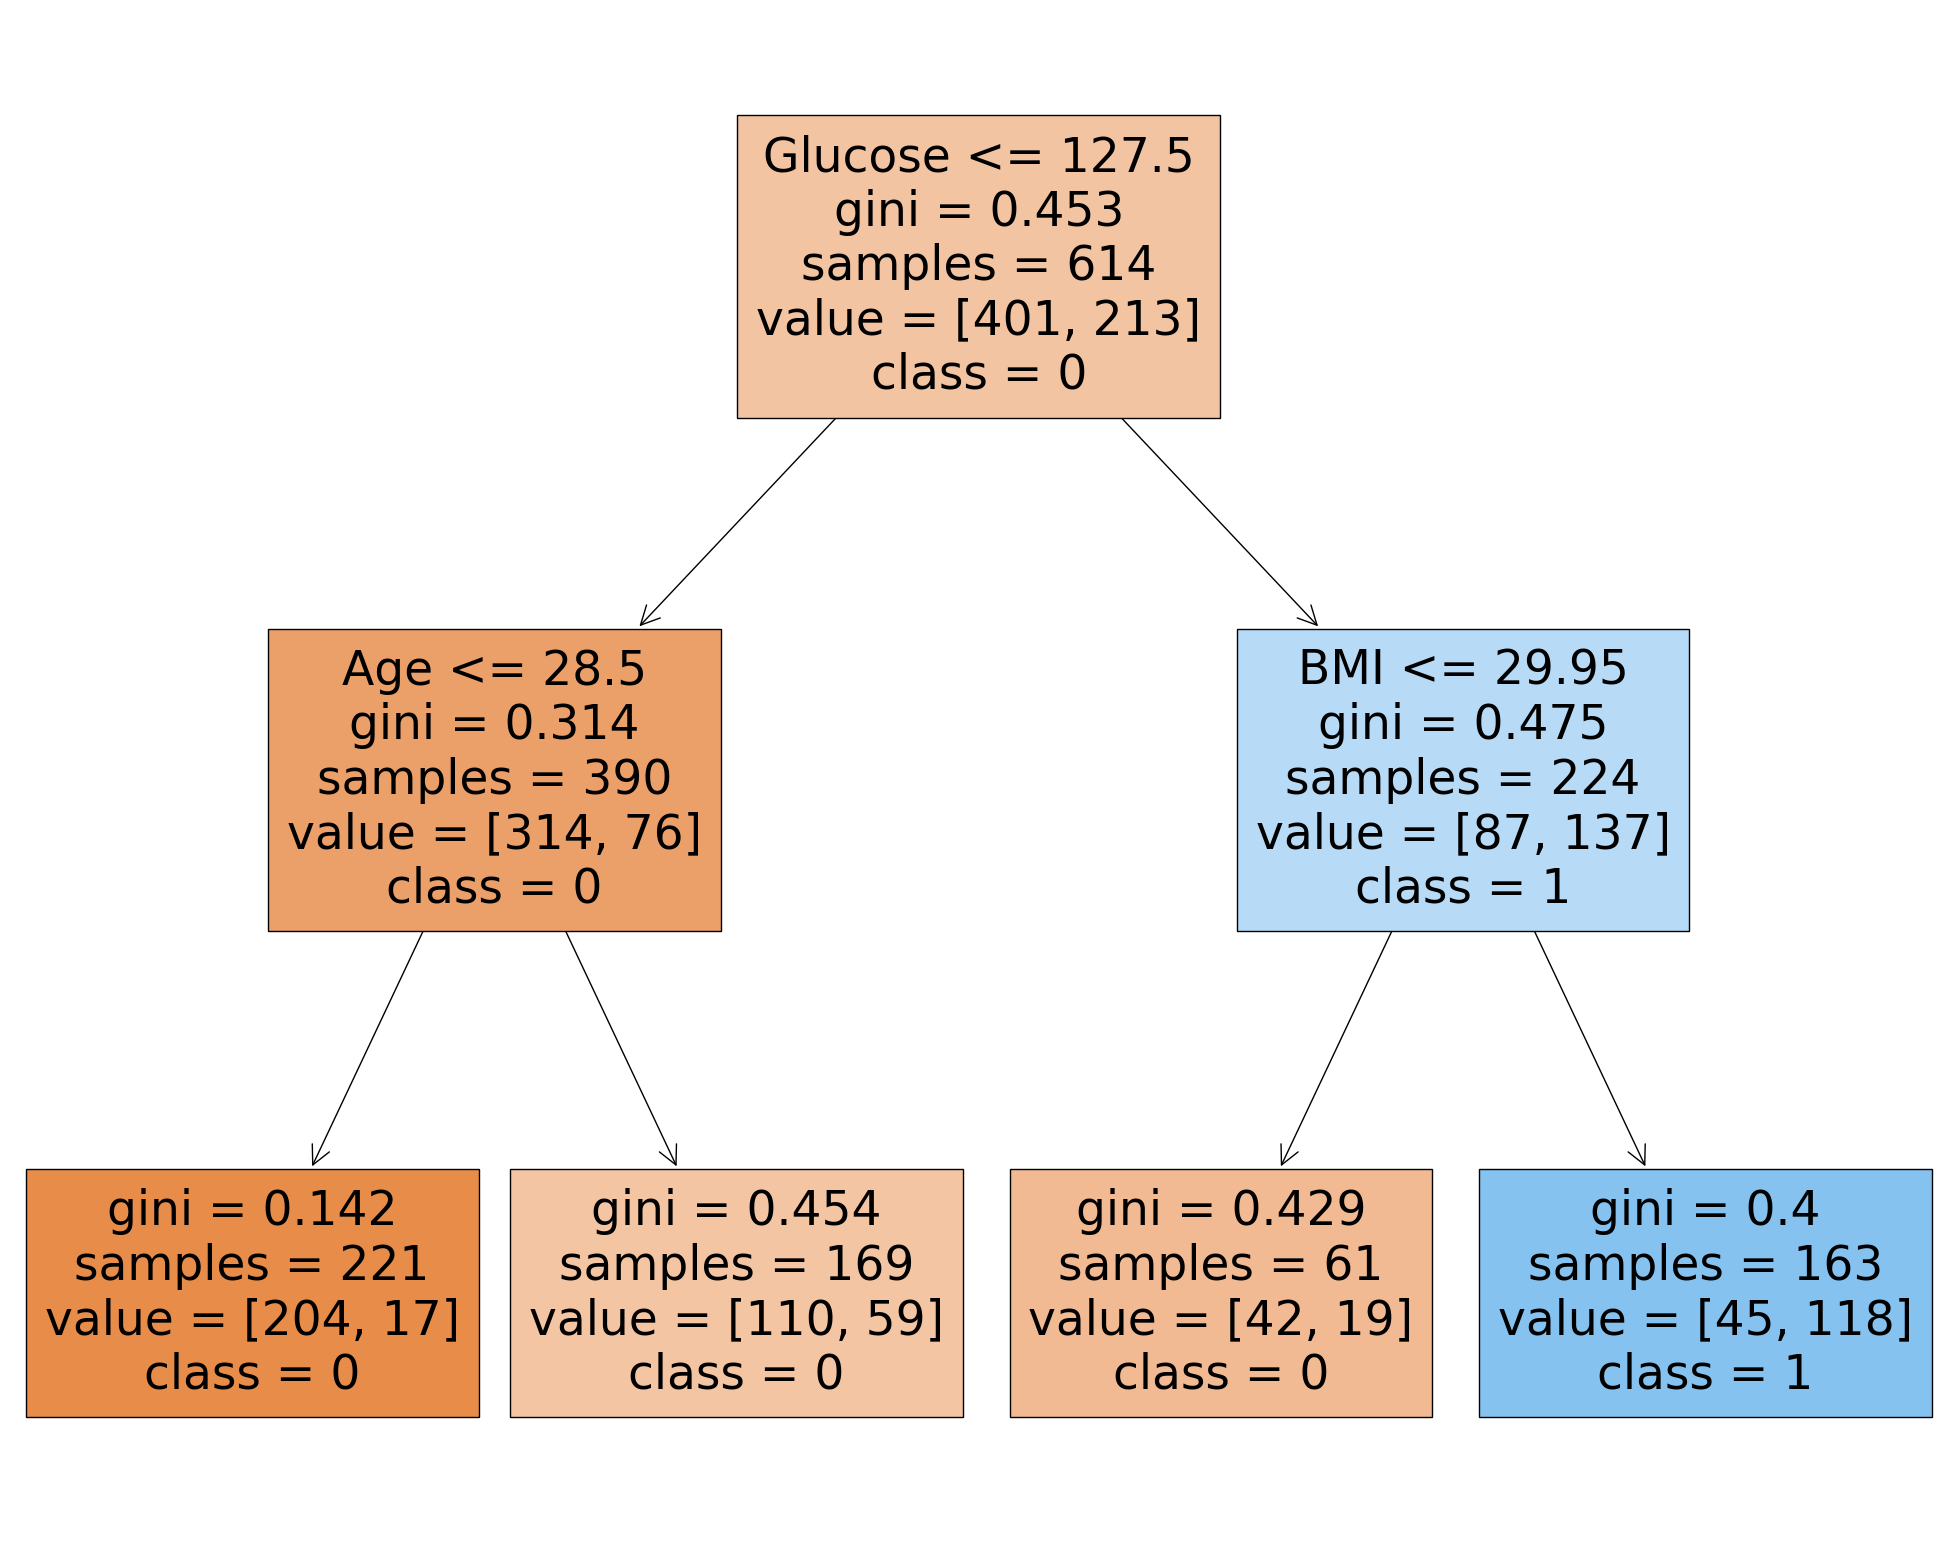

In [417]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(model2, 
                   feature_names=df.columns,  
                   class_names=['0','1'],
                   filled=True)

In [439]:
print(model2.feature_names_in_)
model2.feature_importances_

['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age']


array([0.0000, 0.6279, 0.0000, 0.0000, 0.0000, 0.1919, 0.0000, 0.1803])

<Axes: >

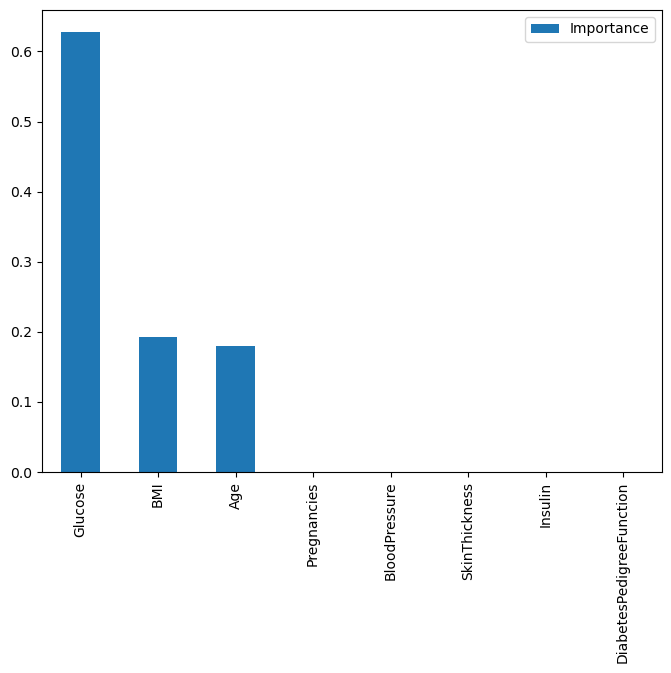

In [429]:
importances = pd.DataFrame(model2.feature_importances_, index=X.columns, columns=["Importance"])
importances.sort_values(by='Importance', ascending=False, inplace=True)
importances.plot(kind='bar', figsize=(8,6))

In [432]:
y_pred = model2.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[87 12]
 [23 32]]


In [446]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X, y, clf=model2, legend=2)

ModuleNotFoundError: No module named 'mlxtend'

## Random Forest - Classifier

In [440]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 40)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=40)

In [443]:
y_prob = model.predict_proba(X_test)[:, 1]
print(np.unique(y_prob, return_counts=True))
roc_auc_score(y_test, y_prob)
# is better than one tree

(array([0.0000, 0.0250, 0.0500, 0.0750, 0.1000, 0.1250, 0.1500, 0.1750,
       0.2000, 0.2250, 0.2500, 0.2750, 0.3000, 0.3250, 0.3500, 0.3750,
       0.4000, 0.4250, 0.4500, 0.4750, 0.5000, 0.5250, 0.5500, 0.5750,
       0.6000, 0.6250, 0.6500, 0.6750, 0.7000, 0.7250, 0.7500, 0.7750,
       0.8000, 0.8500, 0.8750, 0.9250]), array([10,  8,  6,  5,  8,  2,  5, 10,  4,  4,  3,  2,  4,  3,  3,  2,  2,
        5,  2,  4,  4,  2,  5,  6,  2,  2,  7,  5,  2,  3,  8,  2,  5,  3,
        5,  1]))


0.8130394857667586

In [444]:
model.feature_importances_

array([0.0851, 0.2672, 0.0868, 0.0663, 0.0714, 0.1686, 0.1077, 0.1470])

## Support Vector Classifier

In [ ]:
# some SV* kernels (notably rbf) do require X scaling

In [478]:
# refresh data, split, scale, if required
df = df_diabetes_zeros_to_mean
X = df.drop('Outcome', axis=1)
y = df.Outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [479]:
model = SVC(kernel='rbf', probability=True)
model.fit(X_train_scaled, y_train)

SVC(probability=True)

In [480]:
y_prob = model.predict_proba(X_test_scaled)[:, 1]
y_prob[:5]

array([0.3078, 0.0732, 0.1225, 0.2061, 0.4577])

In [481]:
roc_auc_score(y_test, y_prob)

0.8049586776859504

In [483]:
# returns class labels, discrete category
y_pred = model.predict(X_test_scaled)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [484]:
accuracy_score(y_test, y_pred)

0.7337662337662337

In [477]:
y_decision = model.decision_function(X_test_scaled)
y_decision[:5]

array([-0.5237, -1.5803, -1.2320, -0.8527, -0.1319])

In [485]:
# what's the difference between X_test, y_test
# SVC.score (ratio of correctly predicted instances) 
# and metrics.accuracy_score (generic)
model.score(X_test, y_test)

/home/jpm/miniconda3/envs/io-ds/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


0.6428571428571429

In [486]:
confusion_matrix(y_test,y_pred)

array([[82, 17],
       [24, 31]])

In [492]:
model2 = SVC(kernel='rbf', probability=True, gamma=0.01)
model2.fit(X_train_scaled, y_train)
y_prob = model2.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, y_prob)

0.8220385674931129

In [493]:
y_pred = model2.predict(X_test_scaled)
confusion_matrix(y_test,y_pred)
# small improvement with lower Gamma

array([[83, 16],
       [20, 35]])

In [494]:
model3 = SVC(kernel='poly', degree=5, probability=True)
model3.fit(X_train_scaled, y_train)
y_prob = model3.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, y_prob)
# worse AUROC with polynomial SVC

0.7696969696969698

In [495]:
y_pred = model3.predict(X_test_scaled)
confusion_matrix(y_test,y_pred)
# halves false Negatives but increases false Positives, with polynomial SVC

array([[91,  8],
       [34, 21]])

In [1]:
from mlxtend.plotting import plot_decision_regions

In [4]:
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report

In [162]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
        y=X[y == cl, 1],
        alpha=0.8,
        c=colors[idx],
        marker=markers[idx],
        label=f'Class {cl}',
        edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
            c='none', edgecolor='black', alpha=1.0,
            linewidth=1, marker='o',
            s=100, label='Test set')